In [4]:
%pip install Wordcloud
%pip install Sastrawi
%pip install seaborn
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB

from wordcloud import WordCloud, STOPWORDS

In [60]:
!kaggle datasets list -s sentiment-analysis

ref                                                             title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
jp797498e/twitter-entity-sentiment-analysis                     Twitter Sentiment Analysis                         2MB  2021-08-09 02:52:11          48492        281  1.0              
sbhatti/financial-sentiment-analysis                            Financial Sentiment Analysis                     276KB  2022-02-19 21:23:44          14538        125  1.0              
mdismielhossenabir/sentiment-analysis                           Sentiment Analysis                                14KB  2024-01-15 18:48:09           1488         75  1.0              
arkhoshghalb/twitter-sentiment-analysis-hatred-speech           Twitter Sen

In [61]:
!kaggle datasets download mdismielhossenabir/sentiment-analysis

Dataset URL: https://www.kaggle.com/datasets/mdismielhossenabir/sentiment-analysis
License(s): MIT




  0%|          | 0.00/14.3k [00:00<?, ?B/s]
100%|██████████| 14.3k/14.3k [00:00<00:00, 2.74MB/s]


In [62]:
import zipfile

# Tentukan path file zip dan folder tujuan ekstraksi
zip_file_path = 'sentiment-analysis.zip'
extract_path = './extracted_files'

# Ekstraksi file zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("File zip berhasil diekstrak ke folder:", extract_path)


File zip berhasil diekstrak ke folder: ./extracted_files


In [63]:
data = pd.read_csv('./extracted_files/sentiment_analysis.csv')
data.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook
2,2017,8,18,night,Don't angry me,negative,Facebook
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram


## 1. Data Understanding

In [64]:
data.dtypes

Year              int64
Month             int64
Day               int64
Time of Tweet    object
text             object
sentiment        object
Platform         object
dtype: object

In [65]:
data.shape

(499, 7)

In [67]:
data = data.dropna()
data.isnull().sum()

Year             0
Month            0
Day              0
Time of Tweet    0
text             0
sentiment        0
Platform         0
dtype: int64

In [69]:
data = data.drop_duplicates()
data.duplicated().sum()

0

In [71]:
data.describe()

,Year,Month,Day
count,394.000000,394.000000,394.000000
mean,2020.469543,6.083756,15.616751
std,2.863357,3.622883,8.714752
min,2010.000000,1.000000,1.000000
25%,2019.000000,3.000000,8.000000
50%,2021.000000,6.000000,15.000000
75%,2023.000000,9.000000,22.000000
max,2023.000000,12.000000,31.000000


## 2. Preprocessing Text

In [94]:
data.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform
0,2018,8,18,morning,what a great day looks like dream,positive,Twitter
1,2018,8,18,noon,i feel sorry i miss you here in the sea beach,positive,Facebook
2,2017,8,18,night,don t angry me,negative,Facebook
3,2022,6,8,morning,we attend in the class just for listening teac...,negative,Facebook
4,2022,6,8,noon,those who want to go let them go,negative,Instagram


In [95]:
data = data.drop(columns=['Year','Month','Day','Time of Tweet', 'Platform'])
data.head()

,text,sentiment
0,what a great day looks like dream,positive
1,i feel sorry i miss you here in the sea beach,positive
2,don t angry me,negative
3,we attend in the class just for listening teac...,negative
4,those who want to go let them go,negative


In [96]:
# Mengubah data menjadi lowercase
data['text'] = data['text'].str.lower()
data.head()

,text,sentiment
0,what a great day looks like dream,positive
1,i feel sorry i miss you here in the sea beach,positive
2,don t angry me,negative
3,we attend in the class just for listening teac...,negative
4,those who want to go let them go,negative


In [18]:
# Normalisasi
# norm = {"problem" : "masalah", "kwalitas" : "kualitas", "ngaco" : "sembarangan", "aing" : "aku", "tehnologi" : "teknologi", "msh" : "masih", "dl" : "dulu", "donk" : "dong", "kpd" : "kepada", "dg" : "dengan", "jk" : "jika", "kudu" : "harus", "plg" : "paling", "blom" : "belum", "jd" : "jadi", "dg" : "dengan", "iru" : "itu", "duid" : "duit", "bgsd" : "bangsat", "jt" : "juta", "negri" : "negeri", "jln" : "jalan", "hny" : "hanya", "dn" : "dan", "esemka" : "SMK", "brg" : "barang", "batre" : "baterai", "batere" : "baterai", "ujan" : "hujan", "sblm" : "sebelum"}

# def normalisasi(str_text):
#   for i in norm:
#     str_text = str_text.replace(i, norm[i])
#   return str_text

# data['text_cleaning'] = data['text_cleaning'].apply(lambda x: normalisasi(x))

In [97]:
# Stopword
import Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
more_stop_word = []

stop_words = StopWordRemoverFactory().get_stop_words()
new_array = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemover(new_array)

def stopword(str_text):
  str_text = stop_words_remover_new.remove(str_text)
  return str_text

data['text'] = data['text'].apply(lambda x: stopword(x))
data.head()

,text,sentiment
0,what a great day looks like dream,positive
1,i feel sorry i miss you here in the sea beach,positive
2,don t angry me,negative
3,we attend in the class just for listening teac...,negative
4,those who want to go let them go,negative


In [98]:
# Tokenize
tokenized = data['text'].apply(lambda x:x.split())
tokenized

0              [what, a, great, day, looks, like, dream]
1      [i, feel, sorry, i, miss, you, here, in, the, ...
2                                    [don, t, angry, me]
3      [we, attend, in, the, class, just, for, listen...
4              [those, who, want, to, go, let, them, go]
                             ...                        
494    [according, to, a, quarter, of, families, unde...
495    [the, plan, to, not, spend, money, is, not, go...
496    [uploading, all, my, bamboozle, pictures, of, ...
497    [congratulations, you, guys, finish, a, month,...
498    [actually, i, wish, i, was, back, in, tahoe, i...
Name: text, Length: 499, dtype: object

In [99]:
# Stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def stemming(text):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  do = []
  for w in text:
    dt = stemmer.stem(w)
    do.append(dt)
  d_clean = []
  d_clean = " ".join(do)
  print(d_clean)
  return d_clean

tokenized = tokenized.apply(stemming)

tokenized.to_csv('sentiment_analysis_bersih.csv', index=False)
data_clean = pd.read_csv('sentiment_analysis_bersih.csv', encoding='latin1')

what a great day looks like dream
i feel sorry i miss you here in the sea beach
don t angry me
we attend in the class just for listening teachers reading on slide just nonsence
those who want to go let them go
its night 2 am feeling neutral
2 am feedings for the baby are fun when he is all smiles and coos
soooo high
both of you
today first time i arrive in the boat its amazing journey
love is something like e mc 2 rules
i really really like the song cardigan by taylor swift
my sharpie is running dangerously low on ink
i want to go to music tonight but i lost my voice
always somewhere i miss you where i have been
don t distrube me
i don t care who are you and what can you do
i ve been sick for the past few days
i m come back home my past job its really good time for me
i will never fall in love until i found you
maya i m so sorry i hope you find her soon
playing with kids its amazing
is cleaning the house for her family who is comming later today
i tried to shtdown my pc and accenditenl

In [100]:
data_clean.head()

,text
0,what a great day looks like dream
1,i feel sorry i miss you here in the sea beach
2,don t angry me
3,we attend in the class just for listening teac...
4,those who want to go let them go


In [101]:
atribut1 = pd.read_csv('sentiment_analysis_bersih.csv')
atribut2 = pd.read_csv('extracted_files/sentiment_analysis.csv')
merge_atribut = atribut2['sentiment']

data_clean = pd.concat([atribut1, merge_atribut], axis=1)
data_clean

,text,sentiment
0,what a great day looks like dream,positive
1,i feel sorry i miss you here in the sea beach,positive
2,don t angry me,negative
3,we attend in the class just for listening teac...,negative
4,those who want to go let them go,negative
...,...,...
494,according to a quarter of families under six l...,negative
495,the plan to not spend money is not going well,negative
496,uploading all my bamboozle pictures of facebook,neutral
497,congratulations you guys finish a month early ...,positive


In [102]:
# Menghapus nilai NaN
data_clean = data_clean.dropna()
data_clean

,text,sentiment
0,what a great day looks like dream,positive
1,i feel sorry i miss you here in the sea beach,positive
2,don t angry me,negative
3,we attend in the class just for listening teac...,negative
4,those who want to go let them go,negative
...,...,...
494,according to a quarter of families under six l...,negative
495,the plan to not spend money is not going well,negative
496,uploading all my bamboozle pictures of facebook,neutral
497,congratulations you guys finish a month early ...,positive


## 3. Visualisasi Kata

In [108]:
data_negatif = data_clean[data_clean['sentiment'] == 'negative']
data_positif = data_clean[data_clean['sentiment'] == 'positive']
data_netral = data_clean[data_clean['sentiment'] == 'neutral']

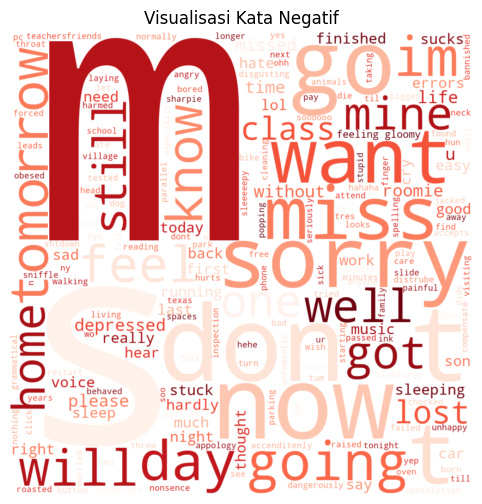

In [107]:
all_text_negatif = ' '.join(word for word in data_negatif["text"])
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_negatif)
plt.figure(figsize=(9, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Visualisasi Kata Negatif")
plt.margins(x=0, y=0)
plt.show()

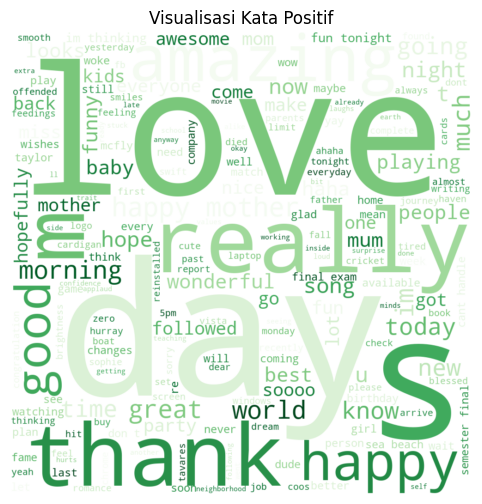

In [109]:
all_text_positif = ' '.join(word for word in data_positif["text"])
wordcloud = WordCloud(colormap='Greens', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_positif)
plt.figure(figsize=(9, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Visualisasi Kata Positif")
plt.margins(x=0, y=0)
plt.show()

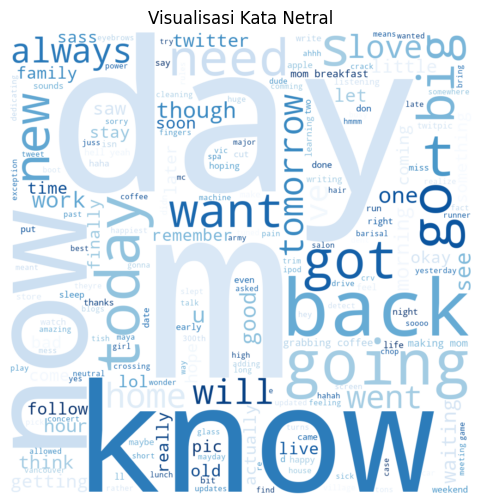

In [110]:
all_text_netral = ' '.join(word for word in data_netral["text"])
wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_netral)
plt.figure(figsize=(9, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Visualisasi Kata Netral")
plt.margins(x=0, y=0)
plt.show()

In [111]:
data_clean['sentiment'].value_counts()

sentiment
neutral     199
positive    166
negative    134
Name: count, dtype: int64

C:\Users\ulima\AppData\Local\Temp\ipykernel_13648\2674841556.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_clean, x='sentiment', palette={'negative': "lightcoral", 'positive': "lightgreen", 'neutral': "lightskyblue"})


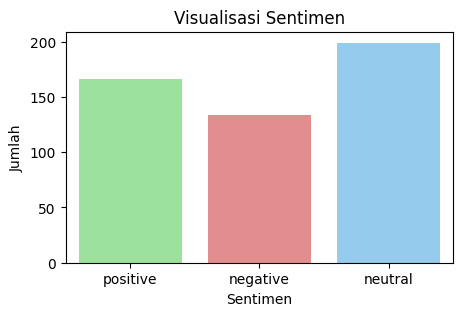

In [113]:
# Visualisasi Sentimen
plt.figure(figsize=(5, 3))
sns.countplot(data=data_clean, x='sentiment', palette={'negative': "lightcoral", 'positive': "lightgreen", 'neutral': "lightskyblue"})
plt.title("Visualisasi Sentimen")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah")
plt.show()

## 4. Data Preparation

In [114]:
# Split data training dan testing
x = data_clean['text']
y = data_clean['sentiment']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [115]:
# Mengubah text menjadi fitur numerik
vectorizer = CountVectorizer()
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)

In [116]:
# Oversampling menggunakan SMOTE pada data train
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_vec, y_train)

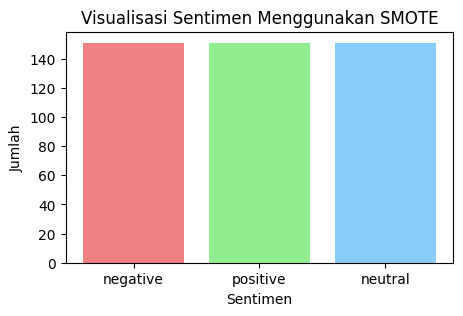

In [117]:
sentimen_counts = y_train_resampled.value_counts()

plt.figure(figsize=(5, 3))
plt.bar(sentimen_counts.index, sentimen_counts.values, color=['lightcoral', 'lightgreen', 'lightskyblue'])
plt.xlabel("Sentimen")
plt.ylabel("Jumlah")
plt.title("Visualisasi Sentimen Menggunakan SMOTE")
plt.xticks(sentimen_counts.index, ['negative', 'positive', 'neutral'])
plt.show()

## 5. Modeling

In [118]:
naive_bayes = MultinomialNB()
naive_bayes.fit(x_train_resampled, y_train_resampled)

MultinomialNB()

In [119]:
y_pred = naive_bayes.predict(x_test_vec)

In [120]:
# Evaluasi Model
accuracy = accuracy_score(y_test, y_pred)
classification = classification_report(y_test, y_pred, target_names=['negative', 'positive', 'neutral'])

print("Akurasi Model Naive Bayes: ", accuracy)
print("\nLaporan Klasifikasi: \n", classification)

Akurasi Model Naive Bayes:  0.6133333333333333

Laporan Klasifikasi: 
               precision    recall  f1-score   support

    negative       0.64      0.48      0.55        48
    positive       0.53      0.67      0.59        48
     neutral       0.69      0.69      0.69        54

    accuracy                           0.61       150
   macro avg       0.62      0.61      0.61       150
weighted avg       0.62      0.61      0.61       150



## 6. Testing

In [129]:
new_comment = input("\nMasukkan comment baru: ")
new_comment_vec = vectorizer.transform([new_comment])
predicted_sentimen = naive_bayes.predict(new_comment_vec)

sentiment_label = predicted_sentimen[0]

print(f"Komentar baru: {new_comment}")
print(f"Sentimen dari komentar baru: {sentiment_label}")

Komentar baru: oh my god, that is so gorgeous
Sentimen dari komentar baru: negative
